# Day 1：数据接入与可视化（WSL2 + venv 环境示例）

目标：
- 给出在 WSL2 中创建并激活 Python 虚拟环境的命令示例；
- 用 AkShare 下载示例股票（日线），并保存为 parquet 与 CSV；
- 绘制收盘价与成交量（以及可选的 K 线图）；
- 做简单的数据质量检查（空值、复权列检查、时间顺序、重复日期）。

说明：在继续之前建议在 WSL2 的 Linux 文件系统中建立项目目录（例如 `~/quant_project`），并在该目录创建虚拟环境。

## 在 WSL2 中创建并激活 venv（示例命令）
在 WSL2 终端中执行：
```bash
mkdir -p ~/quant_project && cd ~/quant_project
python3 -m venv venv
source venv/bin/activate
python -m pip install --upgrade pip setuptools wheel
```
如果你更倾向于 conda，也可以使用 Miniconda/conda 环境。

## 安装快速依赖（在激活的 venv 下运行）
下面是一个最小依赖集合，适合 Day1：
```bash
!pip install --upgrade pip
!pip install akshare pandas pyarrow matplotlib mplfinance jupyterlab
```
（注：在 notebook 中可直接执行带 `!` 的 pip 安装命令；生产/长期建议把依赖写入 requirements.txt 并在 venv 外部用 pip 安装。）

In [1]:
# 环境与库检查（在激活 venv 后运行）
import sys
import platform
import pandas as pd
import numpy as np
import akshare as ak
import matplotlib
import matplotlib.pyplot as plt
print('python', sys.version)
print('platform', platform.platform())
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('akshare', ak.__version__)
print('matplotlib', matplotlib.__version__)


d:\资料库文档\量化\quant_project\.venv\Lib\site-packages\py_mini_racer\py_mini_racer.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


python 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
platform Windows-11-10.0.26100-SP0
pandas 2.3.3
numpy 2.3.4
akshare 1.17.80
matplotlib 3.10.7


## 用 AkShare 下载示例股票日线并保存（示例：中国银行 sh601988）
说明：AkShare 的 `stock_zh_a_daily` 支持 `sh`/`sz` 前缀，例如 `sh601988`, `sz000001`。

In [4]:
import os
import akshare as ak
import fastparquet
# os.makedirs('data', exist_ok=True)

# 示例 symbol，可以替换为你想要的股票代码
symbol = 'sh601988'  # 中国银行示例；改成 'sz000001' 等

# 拉取日线数据
df = ak.stock_zh_a_daily(symbol=symbol)

# 确保有日期列并统一列名（akshare 返回通常包含 'date','open','high','low','close','volume'）
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
else:
    # 如果 index 是日期（少见），重置 index
    df = df.reset_index()

df = df.rename(columns={
    'open':'open', 'high':'high', 'low':'low', 'close':'close', 'volume':'volume'
})

print('download rows:', len(df))
print(df.head())

# 保存为 parquet 与 csv
parquet_path = f'../data/{symbol.replace("/","_")}.parquet'
csv_path = f'../data/{symbol.replace("/","_")}.csv'
df.to_parquet(parquet_path, index=False,engine='fastparquet')
df.to_csv(csv_path, index=False)
print('Saved:', parquet_path, csv_path)


download rows: 4688
        date  open  high   low  close        volume        amount  \
0 2006-07-05  3.99  4.05  3.76   3.79  1.763902e+09  6.846112e+09   
1 2006-07-06  3.75  3.76  3.69   3.72  3.725565e+08  1.386101e+09   
2 2006-07-07  3.72  3.73  3.66   3.68  2.097986e+08  7.736735e+08   
3 2006-07-10  3.68  3.72  3.66   3.70  1.127236e+08  4.161987e+08   
4 2006-07-11  3.71  3.78  3.67   3.75  1.356450e+08  5.027508e+08   

   outstanding_share  turnover  
0       3.454547e+09  0.510603  
1       3.454547e+09  0.107845  
2       3.454547e+09  0.060731  
3       3.454547e+09  0.032631  
4       3.454547e+09  0.039266  
Saved: ../data/sh601988.parquet ../data/sh601988.csv


In [ ]:
# # 修改 notebook 中的代码
# import os
# import akshare as ak
# import pandas as pd

# # 示例 symbol，可以替换为你想要的股票代码
# symbol = 'sh601988'  # 中国银行示例；改成 'sz000001' 等

# print(f"开始下载 {symbol} 数据...")

# try:
#     # 使用 stock_zh_a_daily 接口（已验证可用）
#     df = ak.stock_zh_a_daily(symbol=symbol)
#     print(f"✅ 数据下载成功: {len(df)} 行")
    
#     # 确保有日期列并统一列名
#     if 'date' in df.columns:
#         df['date'] = pd.to_datetime(df['date'])
#     else:
#         # 如果 index 是日期（少见），重置 index
#         df = df.reset_index()

#     # 列名映射（确保列名一致）
#     column_mapping = {
#         'open': 'open', 'high': 'high', 'low': 'low', 'close': 'close', 'volume': 'volume',
#         '开盘': 'open', '收盘': 'close', '最高': 'high', '最低': 'low', '成交量': 'volume'
#     }
    
#     # 只重命名实际存在的列
#     actual_mapping = {k: v for k, v in column_mapping.items() if k in df.columns}
#     df = df.rename(columns=actual_mapping)

#     print('下载行数:', len(df))
#     print('数据列名:', df.columns.tolist())
#     print(df.head())

#     # 保存为 parquet 与 csv
#     os.makedirs('../data', exist_ok=True)
#     parquet_path = f'../data/{symbol.replace("/","_")}.parquet'
#     csv_path = f'../data/{symbol.replace("/","_")}.csv'
    
#     # 使用 pyarrow 引擎保存 parquet
#     df.to_parquet(parquet_path, index=False, engine='pyarrow')
#     df.to_csv(csv_path, index=False)
#     print('保存成功:', parquet_path, csv_path)

# except Exception as e:
#     print(f"❌ 数据下载失败: {e}")
#     import traceback
#     traceback.print_exc()

## 简单数据质量检查
我们检查：空值、重复日期、是否有复权因子（例如 `adj_factor`）、时间是否升序。

In [5]:
# 空值统计
print('null counts:')
print(df.isnull().sum())

# 重复日期
if 'date' in df.columns:
    dup = df['date'].duplicated().sum()
    print('duplicate dates:', dup)

# 时间顺序（是否升序）
if 'date' in df.columns:
    is_sorted = df['date'].is_monotonic_increasing
    print('date is_monotonic_increasing:', is_sorted)
    if not is_sorted:
        df = df.sort_values('date').reset_index(drop=True)

# 复权因子检测（若存在则输出示例）
possible_adj_cols = [c for c in df.columns if 'adj' in c.lower() or '复权' in c]
print('possible adj columns:', possible_adj_cols)
if 'adj_factor' in df.columns:
    print('adj_factor sample:')
    print(df[['date','adj_factor']].tail())
else:
    print('没有发现标准名称的复权因子列（如 adj_factor）。若要用复权价格，请用 Tushare 获取或用复权因子手动计算）。')


null counts:
date                 0
open                 0
high                 0
low                  0
close                0
volume               0
amount               0
outstanding_share    0
turnover             0
dtype: int64
duplicate dates: 0
date is_monotonic_increasing: True
possible adj columns: []
没有发现标准名称的复权因子列（如 adj_factor）。若要用复权价格，请用 Tushare 获取或用复权因子手动计算）。


## 绘制收盘价与成交量（matplotlib）

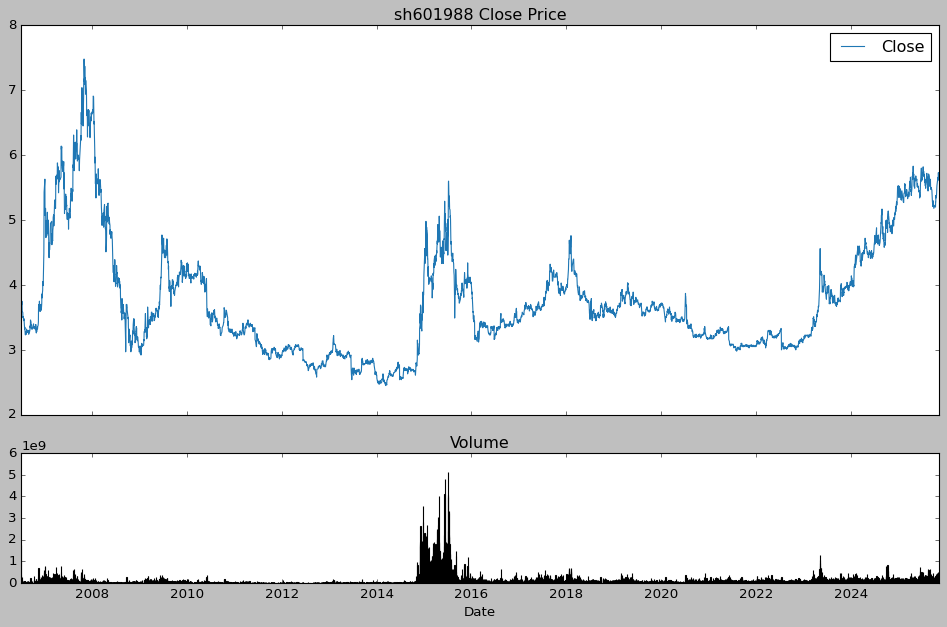

In [6]:
import matplotlib.pyplot as plt
plt.style.use('classic')

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8), gridspec_kw={'height_ratios':[3,1]})
axes[0].plot(df['date'], df['close'], label='Close', color='tab:blue')
axes[0].set_title(f"{symbol} Close Price")
axes[0].legend()
axes[1].bar(df['date'], df['volume'], color='tab:gray')
axes[1].set_title('Volume')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../data/stock_price_volume.png', dpi=300, bbox_inches='tight')
plt.show()



## 可选：绘制 K 线图（mplfinance）
如果已安装 `mplfinance`，下面的代码会画出带成交量的 K 线图。请确保 `date` 列已是 Datetime 且为索引，且列名匹配 `Open/High/Low/Close/Volume`。

In [7]:
try:
    import mplfinance as mpf
    df_k = df.copy()
    df_k['date'] = pd.to_datetime(df_k['date'])
    df_k = df_k.set_index('date')
    # 将列名改为 mplfinance 期望的格式
    rename_map = {}
    for c in ['open','high','low','close','volume']:
        if c in df_k.columns:
            rename_map[c] = c.capitalize() if c != 'volume' else 'Volume'
    df_k = df_k.rename(columns=rename_map)
    # 只保留必要列（若缺列会抛错）
    required_cols = ['Open','High','Low','Close','Volume']
    if all([col in df_k.columns for col in required_cols]):
        mpf.plot(df_k[required_cols], type='candle', volume=True, mav=(5,10,20), figsize=(12,8),savefig='../data/stock_kline.png')
    else:
        print('K线图需要 Open/High/Low/Close/Volume 列，当前数据列为：', df_k.columns.tolist())
except Exception as e:
    print('绘制 K 线图失败（未安装 mplfinance 或数据列不完整）。错误：', e)
    print('可通过 pip install mplfinance 来安装。')


d:\资料库文档\量化\quant_project\.venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


## 小结与下一步
- 你应该在 WSL2 中的项目目录下运行 jupyter lab 或 jupyter notebook：
  ```bash
  jupyter lab --no-browser --ip=0.0.0.0
  ```
  然后在 Windows 浏览器中打开 http://localhost:8888 访问并打开本 notebook。
- 本笔记下载的数据会保存到 `data/` 目录（parquet 与 csv），后续 Day2/Day3 可以直接读取 parquet 做回测与特征工程。
- 其实我是在windows下实现上述代码的，我的wsl崩了 :(\
  你可以和我一样使用
  ```
  python -m jupyter lab
  ```

In [ ]:
# 环境崩了一次

# # 强制重新安装 py_mini_racer
# uv remove py-mini-racer
# uv add py-mini-racer

# # 或者尝试特定版本
# uv remove py-mini-racer
# uv add "py-mini-racer==0.6.0"